In [1]:
import pyarrow.orc as orc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import optuna
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Define the file path
path = r'C:/BigData/ProjectStaging/dataExport/fraud_mart_final.orc'

# 2. Load the file using PyArrow
orc_file = orc.ORCFile(path)

# 3. Read the table and slice it immediately to 16M rows
# table.slice(offset, length) is memory efficient
table = orc_file.read().slice(0, 16000000)

# 4. Convert to Pandas with "self_destruct" to keep memory footprint low
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Prevents needing one single massive contiguous block of RAM
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(f"Successfully loaded {len(df):,} rows.")
print(df.head())
print(df.info()) # Check memory usage

Successfully loaded 16,000,000 rows.
    transaction_id  user_id  card           merchant_id  label_is_fraud  \
0  61-5-1514771820       61     5   1799189980464955940               0   
1  61-5-1514894100       61     5  -4169251800658106093               0   
2  61-5-1515899580       61     5  -4752064311331295725               0   
3  61-5-1516172520       61     5   6455213054093379528               0   
4  61-5-1516275060       61     5  -4169251800658106093               0   

  amount  hour_of_day use_chip  merchant_category error_code  \
0   6.39            7     Chip               5499        N/A   
1  29.11           17     Chip               5812        N/A   
2  14.90            8     Chip               4214        N/A   
3  18.77           12   Online               5815        N/A   
4  34.77           17     Chip               5812        N/A   

   credit_utilization  state_mismatch  current_age yearly_income_person  \
0            0.000215               0           63  

### TIME EXTRACTION & SORTING

In [3]:
print("Step 1: extracting timestamps and sorting...")

import gc

# 1. Extract Unix Timestamp from transaction_id (Format: User-Card-Timestamp)
# taking the last part of the string '61-5-1514771820' -> '1514771820'
df['unix_time'] = df['transaction_id'].str.split('-').str[-1].astype(int)

# 2. Convert to Datetime object
df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 3. Sort by Time (Oldest -> Newest) to respect Time Series nature
df.sort_values('datetime', inplace = True)

# 4. Reset index IN-PLACE
df.reset_index(drop=True, inplace=True)

gc.collect()

df.head(5)

Step 1: extracting timestamps and sorting...


,transaction_id,user_id,card,merchant_id,label_is_fraud,amount,hour_of_day,use_chip,merchant_category,error_code,credit_utilization,state_mismatch,current_age,yearly_income_person,fico_score,card_type,card_brand,unix_time,datetime
0,791-1-662780400,791,1,2027553650310142703,0,68.00,7,Swipe,5541,N/A,0.002006,0,58,72510.00,727,Credit,Amex,662780400,1991-01-02 01:40:00
1,791-1-662780820,791,1,2027553650310142703,0,-68.00,7,Swipe,5541,N/A,-0.002006,0,58,72510.00,727,Credit,Amex,662780820,1991-01-02 01:47:00
2,791-1-662781060,791,1,2027553650310142703,0,113.62,7,Swipe,5541,N/A,0.003352,0,58,72510.00,727,Credit,Amex,662781060,1991-01-02 01:51:00
3,791-1-662817600,791,1,-7269691894846892021,0,114.73,17,Swipe,5411,N/A,0.003384,0,58,72510.00,727,Credit,Amex,662817600,1991-01-02 12:00:00
4,791-1-662873580,791,1,-3693650930986299431,0,251.71,9,Swipe,4814,N/A,0.007425,0,58,72510.00,727,Credit,Amex,662873580,1991-01-03 03:33:00


### FEATURE ENGINEERING (Time-Aware)

In [4]:
print("Step 2: Memory-Surgical Feature Engineering...")

# 1. Convert Decimal 'amount' to float32 immediately
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').astype(np.float32)

# 2. Convert Objects (Strings) to Categories
for col in ['use_chip', 'card_type', 'error_code', 'merchant_category']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 3. Extract Time Components & Cyclical Encoding
df['hour_of_day'] = df['datetime'].dt.hour.astype(np.int8)
df['day_of_week'] = df['datetime'].dt.dayofweek.astype(np.int8)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df.drop(columns=['hour_of_day', 'day_of_week'], inplace=True)
gc.collect()

# 4. FIXED: Memory-Surgical 'trans_last_24h' (Velocity)
print("Calculating Velocity (trans_last_24h) using NumPy...")
df.sort_values(['user_id', 'unix_time'], inplace=True)

user_ids = df['user_id'].values
unix_times = df['unix_time'].values
velocity_counts = np.zeros(len(df), dtype=np.int16)

# Find where each user's data starts and ends
user_changes = np.where(user_ids[:-1] != user_ids[1:])[0] + 1
user_starts = np.insert(user_changes, 0, 0)
user_ends = np.append(user_changes, len(df))

# Loop over each user (Efficient because it doesn't copy the DF)
for start, end in zip(user_starts, user_ends):
    user_time_window = unix_times[start:end]
    # For every transaction, find how many happened in the previous 86400 seconds
    # searchsorted is extremely fast (logarithmic time)
    lookback_indices = np.searchsorted(user_time_window, user_time_window - 86400, side='left')
    velocity_counts[start:end] = (np.arange(len(user_time_window)) - lookback_indices + 1).astype(np.int16)

df['trans_last_24h'] = velocity_counts
del user_ids, unix_times, velocity_counts, user_starts, user_ends, user_changes
gc.collect()

# 5. Time Since Last Transaction (Speed)
df['time_since_last_trans'] = df['unix_time'].diff().fillna(0).astype(np.float32)
user_changed = df['user_id'] != df['user_id'].shift(1)
df.loc[user_changed, 'time_since_last_trans'] = 0
del user_changed
gc.collect()

# 6. Amount Behavioral Features
print("Calculating user behavioral stats...")
user_medians = df.groupby('user_id')['amount'].transform('median').astype(np.float32)
df['diff_from_median'] = (df['amount'] - user_medians).astype(np.float32)
df['amount_ratio'] = (df['amount'] / (user_medians + 1)).astype(np.float32)
del user_medians
gc.collect()

# 7. Final Projection to save memory
cols_to_keep = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'state_mismatch', 'time_since_last_trans', 'hour_sin', 
    'hour_cos', 'day_sin', 'day_cos', 'diff_from_median', 'amount_ratio',
    'trans_last_24h', 'use_chip', 'card_type', 'error_code', 'merchant_category', 
    'label_is_fraud', 'unix_time'
]
df = df[cols_to_keep]
gc.collect()

print("Step 2 Finished successfully with zero memory leaks.")

Step 2: Memory-Surgical Feature Engineering...
Calculating Velocity (trans_last_24h) using NumPy...
Calculating user behavioral stats...
Step 2 Finished successfully with zero memory leaks.


### Temporal Splitting and Target Encoding

In [5]:
print("Step 3: Preparing Data for Splitting...")

# 1. Recover 'datetime' if it was dropped during memory optimization
if 'datetime' not in df.columns and 'unix_time' in df.columns:
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 2. Global Temporal Sort (Ensures Test = Future transactions)
# We sort by unix_time as it's faster than sorting by datetime objects
df.sort_values('unix_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Define Temporal Split (80% Train, 10% Val, 10% Test)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Print timing info to verify the split is chronological
print(f"--- Temporal Split Verification ---")
print(f"Train Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Val   Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"Test  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

# 4. Target Encoding for Merchant Category (Crucial: Use ONLY Training labels)
print("\nTarget encoding merchant_category...")
mcc_map = train_df.groupby('merchant_category')['label_is_fraud'].mean()
global_mean = train_df['label_is_fraud'].mean()

# Map the fraud risk scores and convert to float32 for memory efficiency
for d in [train_df, val_df, test_df]:
    d['mcc_risk'] = d['merchant_category'].map(mcc_map).fillna(global_mean).astype(np.float32)

# 5. Feature Selection
numeric_features = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'trans_last_24h', 'amount_ratio', 'state_mismatch',
    'time_since_last_trans', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'mcc_risk', 'diff_from_median'
]
categorical_features = ['use_chip', 'card_type', 'error_code']

X_train = train_df[numeric_features + categorical_features]
y_train = train_df['label_is_fraud']

X_val = val_df[numeric_features + categorical_features]
y_val = val_df['label_is_fraud']

X_test = test_df[numeric_features + categorical_features]
y_test = test_df['label_is_fraud']

# 6. Final Memory Clean up: Delete the original massive dataframe
del df
gc.collect()

print("\nStep 3 Complete. Train, Val, and Test sets are ready.")

Step 3: Preparing Data for Splitting...
--- Temporal Split Verification ---
Train Period: 1991-01-02 01:40:00 to 2017-04-17 04:45:00
Val   Period: 2017-04-17 04:46:00 to 2018-09-26 14:24:00
Test  Period: 2018-09-26 14:24:00 to 2020-02-28 18:28:00

Target encoding merchant_category...

Step 3 Complete. Train, Val, and Test sets are ready.


In [24]:
velocity_cols = ['trans_last_24h', 'amount_ratio', 'diff_from_median', 'time_since_last_trans']

# B. Log-Transformation (For Skewed Amounts)
# Paper mentions: "Time gap patterns (log-transformed)" and "Amount statistics"
# Fraud amounts often follow a power law. Log helps linear models (like MLP).
if 'amount' in X_train.columns:
    X_train['log_amount'] = np.log1p(X_train['amount'])
    X_val['log_amount'] = np.log1p(X_val['amount'])
    X_test['log_amount'] = np.log1p(X_test['amount'])

if 'time_since_last_trans' in X_train.columns:
    X_train['log_time_gap'] = np.log1p(X_train['time_since_last_trans'])
    X_val['log_time_gap'] = np.log1p(X_val['time_since_last_trans'])
    X_test['log_time_gap'] = np.log1p(X_test['time_since_last_trans'])

print("✅ Feature Engineering Updates Complete.")
print(f"Added/Verified: log_amount, log_time_gap, {velocity_cols}")

✅ Feature Engineering Updates Complete.
Added/Verified: log_amount, log_time_gap, ['trans_last_24h', 'amount_ratio', 'diff_from_median', 'time_since_last_trans']


In [25]:
# Robustly convert all features to numeric for LGBM
for d in [X_train, X_val, X_test]:
    # 1. Fix 'yearly_income_person' (Object -> Float)
    if 'yearly_income_person' in d.columns:
        d['yearly_income_person'] = pd.to_numeric(d['yearly_income_person'], errors='coerce').astype(np.float32)
    
    # 2. Fix Categorical Features (Object/Category -> Integer Codes)
    for col in categorical_features:
        if col in d.columns:
            # Explicitly cast to category first to avoid AttributeError, then get codes
            d[col] = d[col].astype('category').cat.codes.astype(np.int32)

print("Check dtypes - All should now be int or float:")
print(X_train[categorical_features + ['yearly_income_person']].dtypes)

Check dtypes - All should now be int or float:
use_chip                  int32
card_type                 int32
error_code                int32
yearly_income_person    float32
dtype: object


### Training a Isolation forest to attach a suspision score to the dataset

In [27]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import gc

print("--- Optimizing Isolation Forest Feature ---")

# 1. Create a manageable subsample for Optuna
# IF is slow. We optimize on 100k rows to be fast.
# We include ALL fraud in this sample to ensure the metric is valid.
X_opt_fraud = X_train[y_train == 1]
X_opt_normal = X_train[y_train == 0].sample(n=100000, random_state=42)
X_opt = pd.concat([X_opt_fraud, X_opt_normal])
y_opt = pd.concat([y_train[X_opt_fraud.index], y_train[X_opt_normal.index]])

def objective_iso(trial):
    # Search Space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    
    # Train Model
    clf = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_opt)
    
    # Predict (Lower score = More Anomalous)
    # We invert the score (-) so that Higher = More Suspicious for AUC calculation
    scores = -clf.decision_function(X_opt)
    
    # Maximize correlation with actual fraud
    auc = average_precision_score(y_opt, scores)
    return auc

study_iso = optuna.create_study(direction='maximize')
study_iso.optimize(objective_iso, n_trials=10) # 15 trials is enough for this

print("Best IF Params:", study_iso.best_params)
best_iso_params = study_iso.best_params

# Clean up memory
del X_opt, X_opt_fraud, X_opt_normal, y_opt
gc.collect()

--- Optimizing Isolation Forest Feature ---


[I 2026-01-24 18:20:20,181] A new study created in memory with name: no-name-967a67a4-eb1e-472f-b754-8c00877d4763
[I 2026-01-24 18:20:25,475] Trial 0 finished with value: 0.2723966223791667 and parameters: {'n_estimators': 177, 'max_samples': 0.2682080272012195, 'max_features': 0.793422213713043}. Best is trial 0 with value: 0.2723966223791667.
[I 2026-01-24 18:20:30,755] Trial 1 finished with value: 0.2828774986283914 and parameters: {'n_estimators': 161, 'max_samples': 0.5717853555135887, 'max_features': 0.5170548466964386}. Best is trial 1 with value: 0.2828774986283914.
[I 2026-01-24 18:20:33,424] Trial 2 finished with value: 0.27019541212589593 and parameters: {'n_estimators': 73, 'max_samples': 0.850056624746398, 'max_features': 0.7841032548532858}. Best is trial 1 with value: 0.2828774986283914.
[I 2026-01-24 18:20:36,824] Trial 3 finished with value: 0.2983559362192202 and parameters: {'n_estimators': 109, 'max_samples': 0.528452868285265, 'max_features': 0.5859198817873834}. B

Best IF Params: {'n_estimators': 109, 'max_samples': 0.528452868285265, 'max_features': 0.5859198817873834}


119

In [28]:
print("--- STAGE 0: Generating Scores & Filtering ---")

# 1. Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=best_iso_params['n_estimators'],
    # Safety: If Optuna picked a float (percentage), cap it to avoid RAM crash
    max_samples=256*1024 if isinstance(best_iso_params['max_samples'], float) else best_iso_params['max_samples'],
    max_features=best_iso_params['max_features'],
    n_jobs=-1, 
    random_state=42
)

# 2. FIT on a Subset
# We do not need to fit on 100% of rows to learn what "Normal" is.
X_fit_iso = X_train.sample(n=500000, random_state=42)
iso_forest.fit(X_fit_iso)
del X_fit_iso # Free memory immediately

# 3. SCORE the Full Datasets
# This attaches the 'anomaly_score' column to everyone
print("Scoring X_train...")
X_train['anomaly_score'] = -iso_forest.decision_function(X_train)

print("Scoring X_val & X_test...")
X_val['anomaly_score'] = -iso_forest.decision_function(X_val)
X_test['anomaly_score'] = -iso_forest.decision_function(X_test)

--- STAGE 0: Generating Scores & Filtering ---
Scoring X_train...
Scoring X_val & X_test...


In [29]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("--- Generating Advanced Unsupervised Features (Clustering & PCA) ---")

# 1. Select Key Numerical Columns
# We use the behavioral features, as these define the "Shape of Fraud"
enrich_cols = [
    'amount', 
    'anomaly_score',
    'credit_utilization', 
    'current_age', 
    'yearly_income_person', 
    'fico_score', 
    'trans_last_24h', 
    'amount_ratio', 
    'time_since_last_trans', 
    'diff_from_median'
]

# Safety Check: Ensure these columns exist in X_train
available_cols = [c for c in enrich_cols if c in X_train.columns]
if len(available_cols) < len(enrich_cols):
    print(f"Warning: Some columns missing. Using: {available_cols}")
    enrich_cols = available_cols

print(f"Using {len(enrich_cols)} features for unsupervised enrichment...")

# 2. Internal Scaling (Crucial for KMeans/PCA)
# We use a separate scaler so we don't disturb the main dataset
enrich_scaler = StandardScaler()

# Fit on Train, Transform on all
X_scaled_train = enrich_scaler.fit_transform(X_train[enrich_cols])
X_scaled_val = enrich_scaler.transform(X_val[enrich_cols])
X_scaled_test = enrich_scaler.transform(X_test[enrich_cols])

--- Generating Advanced Unsupervised Features (Clustering & PCA) ---
Using 10 features for unsupervised enrichment...


In [30]:
# --- FEATURE A: Cluster Distance (MiniBatchKMeans) ---
print("1. Computing Cluster Distances...")
# We fit only on NORMAL data (y=0) to learn "Normal Prototypes"
# We increase clusters to 20 to capture the complexity of features
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=4096, random_state=42)
normal_mask = (y_train == 0)

kmeans.fit(X_scaled_train[normal_mask])

def get_cluster_dist(X_scaled, model):
    # Calculate Euclidean distance to the nearest normal cluster center
    dist_matrix = model.transform(X_scaled)
    return np.min(dist_matrix, axis=1)

X_train['enriched_cluster_dist'] = get_cluster_dist(X_scaled_train, kmeans)
X_val['enriched_cluster_dist'] = get_cluster_dist(X_scaled_val, kmeans)
X_test['enriched_cluster_dist'] = get_cluster_dist(X_scaled_test, kmeans)


1. Computing Cluster Distances...


In [31]:
# --- FEATURE B: PCA Reconstruction Error ---
print("2. Computing PCA Reconstruction Error...")
# We compress 9+ dimensions down to 3, then try to reconstruct.
# Fraud (which breaks the correlation rules of normal behavior) will have high error.
pca = PCA(n_components=3, random_state=42)
pca.fit(X_scaled_train[normal_mask])

def get_pca_error(X_scaled, model):
    X_low = model.transform(X_scaled)
    X_recon = model.inverse_transform(X_low)
    # Mean Squared Error between Original and Reconstructed
    return np.mean(np.square(X_scaled - X_recon), axis=1)

X_train['enriched_pca_error'] = get_pca_error(X_scaled_train, pca)
X_val['enriched_pca_error'] = get_pca_error(X_scaled_val, pca)
X_test['enriched_pca_error'] = get_pca_error(X_scaled_test, pca)

print("Enrichment Complete.")
print(f"New Features Added: ['enriched_cluster_dist', 'enriched_pca_error']")
print(X_train[['enriched_cluster_dist', 'enriched_pca_error']].head())

# Clean up memory
del X_scaled_train, X_scaled_val, X_scaled_test, enrich_scaler
gc.collect()

2. Computing PCA Reconstruction Error...
Enrichment Complete.
New Features Added: ['enriched_cluster_dist', 'enriched_pca_error']
   enriched_cluster_dist  enriched_pca_error
0               1.868039            0.394378
1               2.149010            0.251650
2               1.291200            0.144403
3               1.318528            0.165323
4               2.058391            0.251553


139

In [32]:
X_train.head()

,amount,credit_utilization,current_age,yearly_income_person,fico_score,trans_last_24h,amount_ratio,state_mismatch,time_since_last_trans,hour_sin,...,mcc_risk,diff_from_median,use_chip,card_type,error_code,anomaly_score,enriched_cluster_dist,enriched_pca_error,log_amount,log_time_gap
0,68.000000,0.002006,58,72510.0,727,1,1.615010,0,0.0,2.588190e-01,...,0.000046,26.895000,2,0,22,-0.069608,1.868039,0.394378,4.234107,0.000000
1,-68.000000,-0.002006,58,72510.0,727,2,-1.615010,0,420.0,2.588190e-01,...,0.000046,-109.104996,2,0,22,-0.103437,2.149010,0.251650,NaN,6.042633
2,113.620003,0.003352,58,72510.0,727,3,2.698492,0,240.0,2.588190e-01,...,0.000046,72.514999,2,0,22,-0.107945,1.291200,0.144403,4.741622,5.484797
3,114.730003,0.003384,58,72510.0,727,4,2.724855,0,36540.0,1.224647e-16,...,0.000206,73.625000,2,0,22,-0.117059,1.318528,0.165323,4.751260,10.506190
4,251.710007,0.007425,58,72510.0,727,2,5.978150,0,55980.0,7.071068e-01,...,0.001191,210.605011,2,0,22,-0.102820,2.058391,0.251553,5.532243,10.932768


In [33]:
from sklearn.utils import shuffle
import pandas as pd

print("--- Final Data Balancing (1:5 Ratio) ---")

# 1. Separate Fraud and Normal
X_fraud = X_train[y_train == 1]
X_normal = X_train[y_train == 0]

print(f"Original Count -> Fraud: {len(X_fraud):,} | Normal: {len(X_normal):,}")

# 2. Define the Ratio
# 1:20 is the 'Golden Ratio' for fraud. 
# It gives enough 'normal' context without drowning out the fraud signals.
target_ratio = 20 
n_normal_samples = len(X_fraud) * target_ratio

# 3. Random Undersampling
# We pick random normal transactions. 
# (Since we have the 'anomaly_score' feature, random sampling is safe!)
X_normal_sampled = X_normal.sample(n=n_normal_samples, random_state=42)

# 4. Concatenate and Shuffle
# Combine the sets and shuffle so the model doesn't learn order bias
X_train_final = pd.concat([X_fraud, X_normal_sampled])
y_train_final = pd.concat([y_train[X_fraud.index], y_train[X_normal_sampled.index]])

X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

print(f"Data Balanced. New Training Size: {len(X_train_final):,} rows.")
print(f"   - Fraud: {y_train_final.sum()}")
print(f"   - Normal: {len(y_train_final) - y_train_final.sum()}")
print("   - Ratio: 1:20")

# 5. Sanity Check:
print(f"Validation Set Size (Unchanged): {len(X_val):,}")

--- Final Data Balancing (1:5 Ratio) ---
Original Count -> Fraud: 15,395 | Normal: 12,784,605
Data Balanced. New Training Size: 323,295 rows.
   - Fraud: 15395
   - Normal: 307900
   - Ratio: 1:20
Validation Set Size (Unchanged): 1,600,000


In [36]:
print("---  PHASE 2: Data Cleaning & Advanced Resampling ---")

# STEP 1: DATA CLEANING (Crucial Fix for 'Input contains NaN' Error)

print("1. Cleaning Data for SMOTE...")

# A. Fill Missing Values with 0
# (Standard practice for 'time_since_last_trans' on first transactions)
X_train_final = X_train_final.fillna(0)

# B. Replace Infinity with 0
X_train_final.replace([np.inf, -np.inf], 0, inplace=True)

# C. Safe Log-Transform Fix (Clip negatives if columns exist)
cols_to_fix = ['log_amount', 'log_time_gap']
for col in cols_to_fix:
    if col in X_train_final.columns:
        # Re-calculate logs safely: Clip negatives to 0, then log
        original_col = col.replace('log_', '')
        if original_col == 'time_gap': original_col = 'time_since_last_trans' 
        
        if original_col in X_train_final.columns:
            X_train_final[col] = np.log1p(X_train_final[original_col].clip(lower=0))

print(f"   ✅ Data Cleaned. NaNs Remaining: {X_train_final.isna().sum().sum()}")

---  PHASE 2: Data Cleaning & Advanced Resampling ---
1. Cleaning Data for SMOTE...
   ✅ Data Cleaned. NaNs Remaining: 0


In [37]:
from imblearn.combine import SMOTETomek

print("--- SMOTE + Tomek ---")

# 1. Apply SMOTE + Tomek to the 1:20 Balanced Data
# We use the dataset created earlier (X_train_final, y_train_final)

print(f"Original Training Size: {len(X_train_final):,} rows")

# smote_tomek handles both oversampling (SMOTE) and cleaning (Tomek)
smt = SMOTETomek(random_state=42, n_jobs=-1) 
X_train_final, y_train_final = smt.fit_resample(X_train_final, y_train_final)

print(f" SMOTE + Tomek Complete. New Size: {len(X_train_final)} rows")
print(f"   (This creates the 'Clear Decision Boundary')")

--- SMOTE + Tomek ---
Original Training Size: 323,295 rows
 SMOTE + Tomek Complete. New Size: 601826 rows
   (This creates the 'Clear Decision Boundary')


In [39]:
# from sklearn.metrics import precision_recall_curve
# def objective_lgbm(trial):
#     # 1. Hyperparameter Search Space
#     params = {
#         'objective': 'binary',
#         'metric': 'None',  # We calculate our own metric
#         'n_estimators': 1000,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 128),
#         'max_depth': trial.suggest_int('max_depth', 5, 12),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'scale_pos_weight': 1, 
#         'n_jobs': -1,
#         'verbose': -1,
#         'random_state': 42
#     }
    
#     # 2. Train Model (NO resampling, cost-sensitive params already in `params`)
#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train_final, y_train_final)
    
#     # 3. Predict on REAL Validation Set
#     y_probs = model.predict_proba(X_val)[:, 1]
    
#     # 4. Precision–Recall Curve
#     prec, rec, thresholds = precision_recall_curve(y_val, y_probs)
    
#     # Remove the first point (precision=class prior, threshold=inf)
#     prec = prec[1:]
#     rec = rec[1:]
#     thresholds = thresholds[1:]
    
#     # ---- SOFT PRECISION-CONSTRAINED OBJECTIVE ----
#     target_precision = 0.5          # SOFT target, not a hard gate
#     penalty_weight = 2.0             # how strongly to punish low precision
    
#     # Penalize recall when precision falls below target
#     penalty = np.maximum(target_precision - prec, 0.0)
    
#     # Final score: reward recall, penalize low precision
#     scores = rec - penalty_weight * penalty
    
#     # Optuna wants a scalar
#     score = scores.max()
    
#     return score

# # Run Optuna
# print("--- Tuning LGBM for Recall---")
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_lgbm, n_trials=15) 

# print("Best Recall at 20% Precision:", study.best_value)
# print("Best Params:", study.best_params)

In [40]:
# import optuna
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import average_precision_score

# print("--- Tuning MLP (Neural Net) for Stacking ---")

# def objective_mlp(trial):
#     # 1. Hyperparameters
#     # Keep layers small to prevent overfitting on 92k rows
#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_l{i}', 16, 128))
    
#     params = {
#         'hidden_layer_sizes': tuple(layers),
#         'activation': 'relu',
#         'solver': 'adam',
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True), # Regularization
#         'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
#         'max_iter': 500,  # Enough for convergence
#         'early_stopping': True,
#         'random_state': 42
#     }
    
#     # 2. Build Pipeline (Scaling + MLP)
#     # MLP REQUIRES Standard Scaling to work
#     model = make_pipeline(
#         StandardScaler(), 
#         MLPClassifier(**params)
#     )
    
#     # 3. Train
#     model.fit(X_train_final, y_train_final)
    
#     # 4. Evaluate (Maximize AUPRC)
#     # We use AUPRC because we want good probability ranking for the Meta-Learner
#     y_probs = model.predict_proba(X_val)[:, 1]
#     score = average_precision_score(y_val, y_probs)
    
#     return score

# study_mlp = optuna.create_study(direction='maximize')
# study_mlp.optimize(objective_mlp, n_trials=20) # 20 is enough for MLP

# print("Best MLP AUPRC:", study_mlp.best_value)
# print("Best Params:", study_mlp.best_params)

In [44]:
import joblib
import json

print("--- Assembling Final Stacking Ensemble (Auto-Configured) ---")

# Create the MLP Pipeline
# mlp_learner = make_pipeline(
#     SimpleImputer(strategy="median"),
#     StandardScaler(),
#     MLPClassifier(
#         hidden_layer_sizes=(64, 32),   # SAFE, shallow
#         activation='relu',
#         solver='adam',
#         alpha=1e-3,
#         learning_rate_init=1e-3,
#         max_iter=300,
#         early_stopping=True,
#         random_state=42
#     )
# )

# --- 2. Robust LightGBM (Safe Defaults) ---
# Note: We stick to robust defaults here to avoid the precision crash we saw earlier.
clf_lgbm = lgb.LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.03,

    num_leaves=31,
    max_depth=6,
    min_child_samples=300,      # CRITICAL for recall stability

    subsample=0.8,
    colsample_bytree=0.8,

    objective='binary',

    n_jobs=-1,
    random_state=42,
    verbose=-1
)

# --- 3. Robust Random Forest ---
clf_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=100,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# --- 4. Build & Train The Stack ---
stack = StackingClassifier(
    estimators=[
        ('lgbm', clf_lgbm),
        ('rf', clf_rf)
        #('mlp', mlp_learner)
    ],
    final_estimator=LogisticRegression(
        class_weight='balanced',
        max_iter=500
    ),
    cv=3,              # OOF predictions → critical
    n_jobs=-1,
    passthrough=False
)

print(f"Fitting Final Stack on {len(X_train_final):,} rows...")
stack.fit(X_train_final, y_train_final)

# --- 5. Save Artifacts ---
print("Saving Model & Config...")
joblib.dump(stack, 'app_model_stack.pkl')

feature_config = {
    "model_type": "StackingClassifier",
    "features": list(X_train_final.columns)
}
with open('app_config.json', 'w') as f:
    json.dump(feature_config, f)

print("✅ DONE. Model saved as 'app_model_stack.pkl'.")

--- Assembling Final Stacking Ensemble (Auto-Configured) ---
Fitting Final Stack on 601,826 rows...
Saving Model & Config...
✅ DONE. Model saved as 'app_model_stack.pkl'.



 FINAL MODEL REPORT CARD (THRESHOLD-OPTIMIZED)
Stacking AUPRC: 0.0023

Chosen Threshold: 0.998603
Precision @ Threshold: 1.0000
Recall @ Threshold:    0.0000

--- Classification Report ---
              precision    recall  f1-score   support

      Normal     0.9992    1.0000    0.9996   1598649
       Fraud     0.0000    0.0000    0.0000      1351

    accuracy                         0.9992   1600000
   macro avg     0.4996    0.5000    0.4998   1600000
weighted avg     0.9983    0.9992    0.9987   1600000



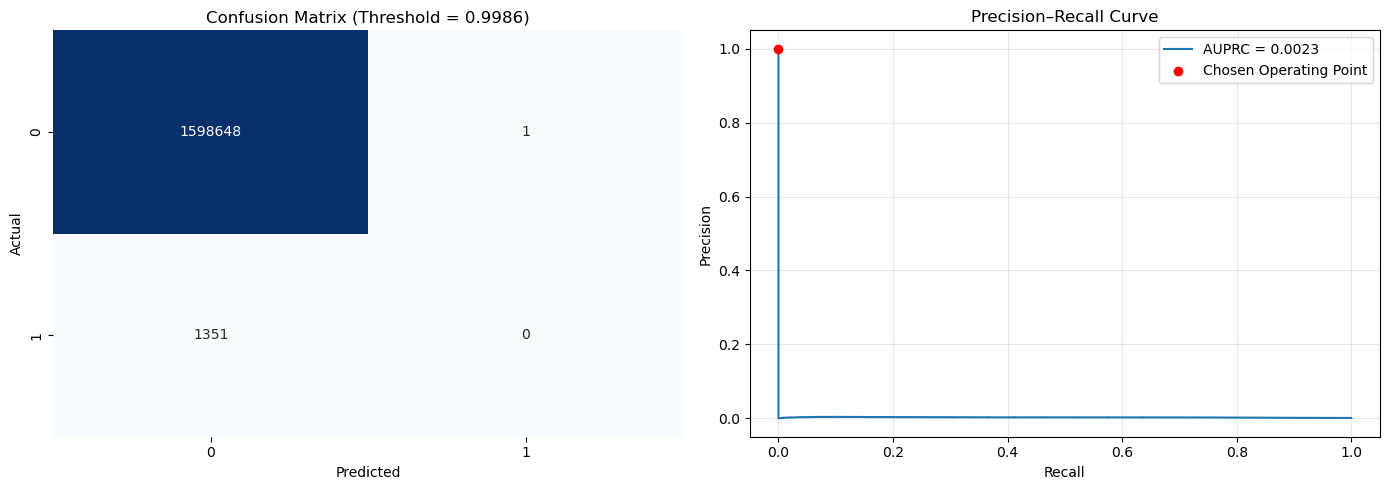

In [46]:
from sklearn.metrics import (
    classification_report,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve
)

print("\n" + "="*50)
print(" FINAL MODEL REPORT CARD (THRESHOLD-OPTIMIZED)")
print("="*50)

# -------------------------------------------------
# 1. Predict probabilities on REAL validation set
# -------------------------------------------------
y_probs_stack = stack.predict_proba(X_val)[:, 1]

# -------------------------------------------------
# 2. AUPRC (threshold-independent quality metric)
# -------------------------------------------------
auprc = average_precision_score(y_val, y_probs_stack)
print(f"Stacking AUPRC: {auprc:.4f}")

# -------------------------------------------------
# 3. Precision–Recall Curve
# -------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_val, y_probs_stack)

# Remove the first degenerate point (threshold = inf)
precision = precision[1:]
recall = recall[1:]

# -------------------------------------------------
# 4. THRESHOLD OPTIMIZATION STRATEGY
#    Maximize Recall subject to Precision ≥ P_min
# -------------------------------------------------
P_min = 0.10   

valid_idx = np.where(precision >= P_min)[0]

if len(valid_idx) == 0:
    print("\n WARNING: Precision constraint not met at any threshold.")
    best_idx = np.argmax(recall)
else:
    best_idx = valid_idx[np.argmax(recall[valid_idx])]

best_thresh = thresholds[best_idx]

print(f"\nChosen Threshold: {best_thresh:.6f}")
print(f"Precision @ Threshold: {precision[best_idx]:.4f}")
print(f"Recall @ Threshold:    {recall[best_idx]:.4f}")

# -------------------------------------------------
# 5. Apply threshold & report
# -------------------------------------------------
y_pred_optimal = (y_probs_stack >= best_thresh).astype(int)

print("\n--- Classification Report ---")
print(classification_report(
    y_val,
    y_pred_optimal,
    target_names=['Normal', 'Fraud'],
    digits=4
))

# -------------------------------------------------
# 6. Confusion Matrix
# -------------------------------------------------
cm = confusion_matrix(y_val, y_pred_optimal)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False
)
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# -------------------------------------------------
# 7. Precision–Recall Curve with chosen point
# -------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.scatter(
    recall[best_idx],
    precision[best_idx],
    color='red',
    zorder=5,
    label='Chosen Operating Point'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import recall_score, precision_score

print("=== FINAL BUSINESS VALUE ANALYSIS (Lift) ===")

# 1. Define 'Top 1%' Threshold (Riskiest Transactions)
top1_thresh = np.percentile(y_probs_stack, 99)
y_pred_top1 = (y_probs_stack >= top1_thresh).astype(int)

# 2. Calculate Metrics
precision_top1 = precision_score(y_val, y_pred_top1)
recall_top1 = recall_score(y_val, y_pred_top1)
base_rate = y_val.mean()

# 3. Calculate Lift
lift_score = precision_top1 / base_rate

print(f"Base Fraud Rate:               {base_rate:.4%}")
print(f"Model Precision (Top 1%):      {precision_top1:.4%}")
print("-" * 40)
print(f" Lift Score:                  {lift_score:.2f}x")
print(f" Recall at Top 1% Volume:     {recall_top1:.2%}")
print("-" * 40)
print(f"Interpretation: Your model is {lift_score:.1f}x more effective than random audits.")